In [208]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import *
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import random
import matplotlib.pyplot as plt

In [209]:
# 데이터 형상 관련 상수
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL = 3

In [210]:
# 학습 데이터 준비하기

In [211]:
path = r"Q:\Python_Data\dogs-vs-cats"
os.listdir(path)

['sampleSubmission.csv', 'test1', 'train']

In [212]:
train_path = path + '/train'
test_path = path + '/test1'

In [213]:
filenames = os.listdir(train_path)
categories = []
for filename in filenames:
    category = filename.split(".")[0]
    if category == "dog":
        categories.append(1)
    else:
        categories.append(0)
df = pd.DataFrame({'filename' : filenames,
               'category' : categories})

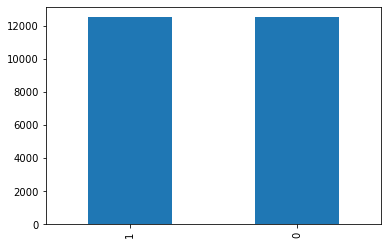

In [214]:
df['category'].value_counts().plot.bar() # 개와 고양이가 동일 비율로 존재

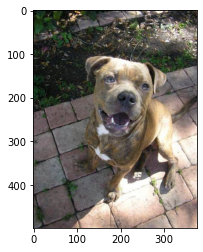

In [215]:
sample = random.choice(filenames) # 랜덤으로 1개의 이미지 뽑기
img = load_img(train_path + f"/{sample}")
plt.imshow(img)

In [216]:
"""
배치 정규화(Batch Normalizationi)
> 신경망 입력 데이터를 평균 : 0, 분산 : 1 로 정규화를 해서
학습이 잘 이루어지도록 하는 것
> 배치 내부에서의 정규화를 진행한다는 것 
> 기존의 전체 데이터에 대해서 정규화 하는 것과는 다르다.

강아지 - 레이어 1
        conv
        batchNorm  <- 새로 추가된 구조
        pool
        dropout
"""

'\n배치 정규화(Batch Normalizationi)\n> 신경망 입력 데이터를 평균 : 0, 분산 : 1 로 정규화를 해서\n학습이 잘 이루어지도록 하는 것\n> 배치 내부에서의 정규화를 진행한다는 것 \n> 기존의 전체 데이터에 대해서 정규화 하는 것과는 다르다.\n\n강아지 - 레이어 1\n        conv\n        batchNorm  <- 새로 추가된 구조\n        pool\n        dropout\n'

In [217]:
from keras.models import Sequential
from keras.layers import *

In [218]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu',
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu',))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu',))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu',))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation=('softmax')))

In [219]:
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_55 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_56 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 30, 30, 64)      

In [220]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

earlyStop = EarlyStopping(monitor='val_loss', patience=10)

In [221]:
learning_rate_reduction = ReduceLROnPlateau(moniter = 'val_accuracy',
                                            patience = 2,
                                            factor = 0.5,
                                            min_lr = 1e-5,
                                            verbose=1)

In [222]:
callbacks = [earlyStop, learning_rate_reduction]

In [223]:
# 이미지 제너레이터에서 class_mode='categorical'로 지정학 ㅣ위해서
df['category'] = df['category'].replace({0:'cat', 1:'dog'})

In [224]:
trn, val = train_test_split(df, test_size=0.2, random_state=42)

In [225]:
trn = trn.reset_index(drop=True)
trn
val = val.reset_index(drop=True)
val

,filename,category
0,cat.493.jpg,cat
1,dog.9112.jpg,dog
2,cat.745.jpg,cat
3,dog.11022.jpg,dog
4,dog.11363.jpg,dog
...,...,...
4995,cat.6551.jpg,cat
4996,cat.9403.jpg,cat
4997,cat.236.jpg,cat
4998,dog.6530.jpg,dog


In [245]:
batch_size = 32
trn_len = trn.shape[0]
val_len = val.shape[0]

In [246]:
val_len

5000

In [247]:
# 트레인 데이터 제너레이터 설정

In [248]:
train_datagen =  ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                  )

train_datagen_set = train_datagen.flow_from_dataframe(trn, 
                                      r"Q:\Python_Data\dogs-vs-cats\train\\",
                                      x_col = 'filename',
                                      y_col = 'category',
                                      target_size=IMAGE_SIZE,
                                      class_mode ='categorical',
                                      batch_size= batch_size
                                     )

Found 20000 validated image filenames belonging to 2 classes.


In [249]:
validation_datagen = ImageDataGenerator(rescale=1./255)
val_datagen_set = validation_datagen.flow_from_dataframe(val, 
                                      r"Q:\Python_Data\dogs-vs-cats\train\\",
                                      x_col = 'filename',
                                      y_col = 'category',
                                      target_size=IMAGE_SIZE,
                                      class_mode ='categorical',
                                      batch_size= batch_size
                                     )

Found 5000 validated image filenames belonging to 2 classes.


In [250]:
example = val.sample(n=1).reset_index(drop=True)
example

,filename,category
0,dog.9288.jpg,dog


In [251]:
example_gen = train_datagen.flow_from_dataframe(example,
                                  r"Q:\Python_Data\dogs-vs-cats\train\\",
                                  x_col = 'filename',
                                  y_col = 'category',
                                  target_size=IMAGE_SIZE,
                                  class_mode ='categorical',
                                  batch_size= batch_size
                                 )

Found 1 validated image filenames belonging to 1 classes.


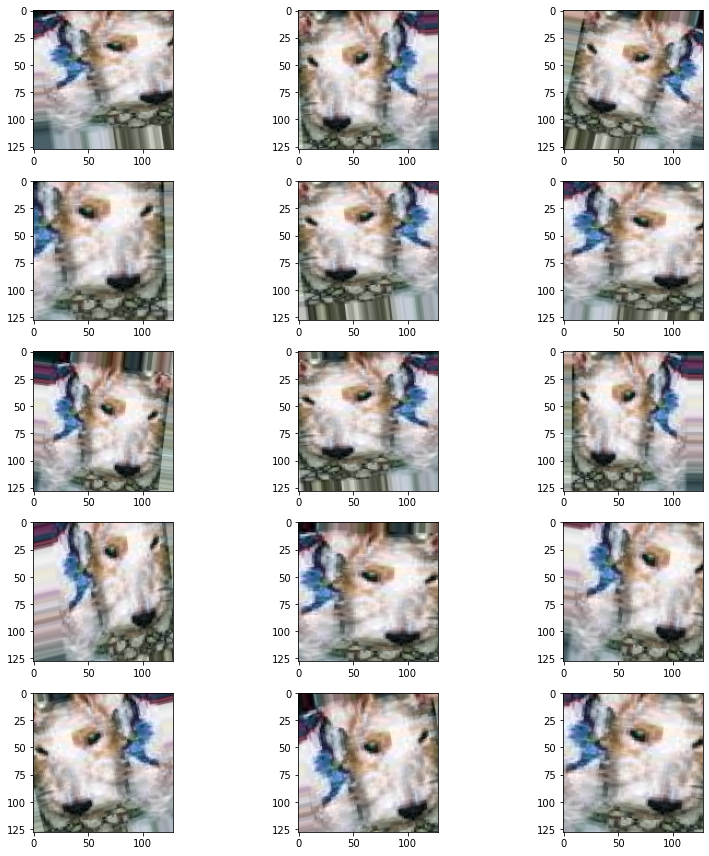

In [252]:
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for xBatch, yBatch in example_gen:
        image = xBatch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [262]:
FAST_RUN = True
epochs = 3 if FAST_RUN else 50

In [263]:
history = model.fit_generator(train_datagen_set,
                              epochs=epochs,
                              steps_per_epoch = trn_len//batch_size,
                              validation_data = val_datagen_set,
                              validation_steps = val_len//batch_size,
                              callbacks=callbacks
                             )

Epoch 1/3
625/625 [==============================] - 117s 188ms/step - loss: 0.1730 - accuracy: 0.9316 - val_loss: 0.3003 - val_accuracy: 0.9447
Epoch 2/3
625/625 [==============================] - 110s 176ms/step - loss: 0.1754 - accuracy: 0.9297 - val_loss: 0.1472 - val_accuracy: 0.9493
Epoch 3/3
625/625 [==============================] - 111s 178ms/step - loss: 0.1749 - accuracy: 0.9322 - val_loss: 0.1542 - val_accuracy: 0.9452


In [264]:
history.history['loss']
history.history['val_loss']
history.history['accuracy']
history.history['val_accuracy']

[0.9447115659713745, 0.9492753744125366, 0.945249617099762]

In [267]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=(['loss', 'accuracy']))
fig.add_trace(go.Scatter(x=[1, 2, 3], y=history.history['loss'], name='loss'),
             row=1, col=1)
fig.add_trace(go.Scatter(x=[1, 2, 3], y=history.history['val_loss'], name='val_loss'),
             row=1, col=1)
fig.add_trace(go.Scatter(x=[1, 2, 3], y=history.history['accuracy'], name='accuracy'),
             row=1, col=2)
fig.add_trace(go.Scatter(x=[1, 2, 3], y=history.history['val_accuracy'], name='val_accuracy'),
             row=1, col=2)

fig.update_layout(title='<br>결과 확인</br>',)
fig.show()

# 테스트 데이터

In [304]:
# 테스트 데이터
filenames = os.listdir(test_path)
categories = []
for filename in filenames:
    category = filename.split(".")[0]
    if category == "dog":
        categories.append(1)
    else:
        categories.append(0)
test_df = pd.DataFrame({'filename' : filenames,
               'category' : categories})

In [305]:
test_df['category'] = test_df['category'].replace({0:'cat', 1:'dog'})

In [310]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen_set = test_datagen.flow_from_dataframe(test_df,
                                      r"Q:\Python_Data\dogs-vs-cats\test1\\",
                                      x_col = 'filename',
                                      y_col = None,
                                      target_size=IMAGE_SIZE,
                                      class_mode = None,
                                      batch_size= batch_size
                                     )

Found 12500 validated image filenames.


In [311]:
test_len = test_df.shape[0]

In [312]:
pred = model.predict_generator(test_datagen_set, 
                            steps=test_len//batch_size
                           )

In [313]:
test_df['category'] = test_df['category'].replace({'cat':0, 'dog':1})
sum(np.argmax(pred, axis=1) == np.array(test_df['category']))/len(pred)

C:\Users\chan\anaconda3\envs\tf15_py37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



TypeError: 'bool' object is not iterable

In [314]:
sum(np.argmax(pred, axis=1) == np.array(test_df['category'])[:12480])/len(pred)

0.4909455128205128

In [198]:
import keras
fm = keras.datasets.fashion_mnist
(trnImg, trnLbl), (tstImg, tstLbl) = fm.load_data()

4423680/4422102 [==============================] - 3s 1us/step
